In [1]:
#############################################################
# 1. Libraries

import pandas as pd
import numpy as np 
import os
import glob
import tqdm

import matplotlib.pyplot as plt
import gc
from numpy.fft import *
from scipy import signal
from joblib import parallel_backend, Parallel, delayed
from skimage import color, io
from PIL import Image               # to load images
import IPython

import librosa
import librosa.display
import gc

#############################################################

In [2]:
#############################################################
# 2. Paths & Global Variables

## 2.1 Paths

path = '../../01_Data/'
path_sequences = path + '01_GeneratedSequences/'
path_spectograms = path + '02_GeneratedSpectograms_1/'

df_train = pd.read_csv(path + 'train.csv')
df_sample_submission = pd.read_csv(path + 'sample_submission.csv') 

train_paths = glob.glob(path + 'train/*')
test_paths = glob.glob(path + 'test/*')

unique_segments_id_train = set(df_train['segment_id'])
unique_segments_id_test = set(df_sample_submission['segment_id'])

dict_unique_segments_train_id = { v : k for k, v in enumerate(unique_segments_id_train)}
dict_unique_segments_train_id_inv = { k : v for k, v in enumerate(unique_segments_id_train)}

## 2.2 Global Variables

SEQ_LENGTH = 60_001

#############################################################

In [3]:
#############################################################
# 3. Preprocess

dict_segments_paths_train = {
    segment : path + 'train/' + str(segment) + '.csv' for segment in unique_segments_id_train
}

dict_segments_paths_test = {
    segment : path + 'test/' + str(segment) + '.csv' for segment in unique_segments_id_test
}


dict_segments_sequences_paths_train = {
    segment : path_sequences + 'train/' + str(segment) + '.npy' for segment in unique_segments_id_train
}

dict_segments_sequences_paths_test = {
    segment : path_sequences + 'test/' + str(segment) + '.npy' for segment in unique_segments_id_test
}


#############################################################

In [4]:
SAMPLING_RATE = 100 
DURATION = 600
SAMPLES = SAMPLING_RATE * DURATION
N_MELS = 128
HOP_LENGTH = 256 # 256
FMIN = 0
FMAX = SAMPLING_RATE // 2
N_FFT = N_MELS * 20 #2048

def readFile(pathname, sensor=0, mask_value=0):
    y = pd.read_csv(pathname).fillna(mask_value).values[-SAMPLES:, sensor]
    return y


def gestft(file, sensor, mask_value=0.0):
    x = np.load(file, allow_pickle=True)
    fs = 100                
    n = 256 
    f, t, Z = signal.stft(x[:, sensor],
                                fs = fs, 
                                window = 'hann', 
                                nperseg = n) 
    Z = np.abs(Z)

    return f, t, Z


def monoToColor(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
#     X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V



In [5]:
def dumpSpectoGrams(segment, path_output, paths_files, mask_value=0):
    if not os.path.exists(f'{path_output}/{segment}/'):
        os.makedirs(f'{path_output}/{segment}/') 
        
        for s in range(10):
            f, t, Z = gestft(paths_files[segment], sensor=s, mask_value=mask_value)

            img = plt.pcolormesh(t, f, Z, vmin=0, vmax=Z.mean() * 10)
            img = img.get_array().reshape(img._meshWidth, img._meshHeight)
            img = monoToColor(img)
            np.save(f'{path_output}{segment}/{segment}_{s}.npy', np.expand_dims(img.data, -1))
            
#         # Clear the current axes.
#         plt.cla() 
#         fig.clf()
#         # Clear the current figure.
#         plt.clf() 
#         # Closes all the figure windows.
        plt.close('all')
        # Clerar garbage
        del f, t, Z, img
        gc.collect()

C:\Users\Enric\anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\Enric\anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


KeyboardInterrupt: 

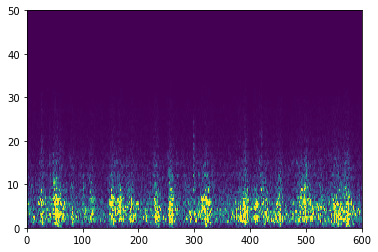

In [6]:
path_output = path + '05_GeneratedSpectogramsSTFT_2/'

for segment in tqdm.tqdm_notebook(dict_segments_paths_train, total=len(dict_segments_sequences_paths_train), position=0):
    dumpSpectoGrams(segment, path_output + 'train/', dict_segments_sequences_paths_train, mask_value=0) 
    
print('Train finished!')

for segment in tqdm.tqdm_notebook(dict_segments_paths_test, total=len(dict_segments_paths_test), position=0):
    dumpSpectoGrams(segment, path_output + 'test/', dict_segments_sequences_paths_test, mask_value=0) 
    
print('Test finished!')

In [ ]:
# dumpSpectoGrams(path_spectograms, dict_segments_paths_train, mask_value=0)

# num_processors = 16
# path_output = path + '05_GeneratedSpectogramsSTFT_2/'

# with parallel_backend('threading', n_jobs=num_processors):
#     Parallel()(delayed(dumpSpectoGrams)(segment, path_output + 'train/', dict_segments_sequences_paths_train, 
#                                         mask_value=0) 
#               for segment in dict_segments_paths_train)
    
# print('Train finished!')
    
# with parallel_backend('threading', n_jobs=num_processors):
#     Parallel()(delayed(dumpSpectoGrams)(segment, path_output + 'test/', dict_segments_sequences_paths_test, mask_value=0) 
#               for segment in dict_segments_paths_test)
    
# print('Test finished!')